## Biodiversity Intactness Index change in Phoenix, AZ
Mapping biodiversity loss from urban expansion in the Phoenix metropolitan region. 
 
#### Author *Isabella Segarra*
[Link to Github repository](hhttps://github.com/IsabellaSegarra/biodiversity-intactness)

### Objective
Urbanization poses a significant threat to local biodiversity. In the Phoenix, AZ subdivision, urban development saw the largest increase in the country between 2001 and 2021. In this analysis, I examine how biodiversity changed between 2017 and 2020 and highlight the extent to which rapid urban growth has contributed to biodiversity loss.

### About the data
#### Biodiversity Intactness Index (BII) Time Series  
In order to quantify biodiversity loss, I will utilize the Biodiversity Intactness Index Time Series data through the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). This dataset, which is produced by the [Impact Observatory](https://www.impactobservatory.com/) with Vizzuality, is raster (`.tiff` file) data taken at 100m resolution from 2017-2020. Biodiversity Intactness is estimated as a combination of abundance and compositional similarity or how similar the composition of species is to its baseline for the region. These methods can be read in Gassert et. al 2022 paper entitled "Global 100m Projections of Biodiversity Intactness for the years 2017-2020". 

#### Phoenix Subdivision Shapefile
In order to map biodiversity loss, I will utilize the [U.S. Census TIGER shapefile](https://catalog.data.gov/dataset/tiger-line-shapefile-2023-state-arizona-az-county-subdivision) for Arizona. TIGER (Topologically Integrated Geographic Encoding and Referencing) shapefiles are geographic data for mapping with information from the U.S. Census Bureau's Master Address File (MTDB). I will subset this data to the Phoenix subdivision. 

### Analysis Highlights
In this analysis, I will perform the following:
1. Access the `io-biodiversity` catalog from the Microsoft Planetary Computer.
2. Specialize a search based on select time range and coordinates for the Phoenix subdivision.
3. Clip raster data to the extent of the Phoenix boundary.
4. Mask raster data to remove cells before performing raster algebra. 
4. Perform raster algebra.
5. Produce a map of biodiversity loss from 2017 to 2020. 


1. **Import the necessary packages**

In [1]:
# Environment set-up 
import pandas as pd # for data wrangling
import numpy as np  # for data wrangling 

import geopandas as gpd # for geospatial data 
import os # for data import

import matplotlib.pyplot as plt  # for visualizations 
import contextily as cx # for basemaps 

import rioxarray as rio # for raster data 

from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

from shapely.geometry import box 
import matplotlib.patches as mpatches # for visualizatons 

## Data import and exploration

### Biodiversity Intactness Index (BII) Time Series 
In this step I will acess the `io-biodiversity` catalog from the *Microsoft Planetary Computer*.

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Access collections
catalog.get_collections() 
# Turn generator into list 
collections = list(catalog.get_collections()) 

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the io-biodiversity collection
io_biodiversity = catalog.get_child('io-biodiversity')
io_biodiversity

Number of collections: 126


<CollectionClient id=io-biodiversity>

In [3]:
# Explore catalog metadata 
print('Title:', io_biodiversity.title)
print('Description: ', io_biodiversity.description)

Title: Biodiversity Intactness
Description:  Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020.

Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between observed biodiversity m

**Data Exploration Findings**:

From acessing the biodiveristy catalog from the MPC, I learned the following:
- description of the catalog
- resolution of the data (100 m)
- that the data is a .tif file or raster data


Further refine the `io-biodiversiry` to 2017 and 2020 rasters and with the following coordinates to match the Pheonix, AZ region.

[-112.826843, 32.974108, -111.184387, 33.863574]

In [4]:
# Time range of study (YEAR-MONTH-DAY)
time_range = "2017-01-01/2020-12-31" 

In [5]:
# Bounding box of region
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

Create a catalog search within the `io-biodiversity` collection to the bbox and time range specified earlier.

In [6]:
# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'], # Same collection
    bbox = bbox,  # Bbox coordiantes
    datetime = time_range) # Specified time range 

# Get items from search
items = search.item_collection() 

# Determine number of items in search
len(items)

4

This catalog now contains the time range 2017-2020, including the years in between. In this next section I searched the items to see which feature corresponds to the years I want: 2017 and 2020.

In [7]:
# Find the years from the items
# Open features >> properties >>  inspect which features correspond to 2017 and 2020
items

Index to the years I want from the `items`. From viewing the item I saw that item 0 corresponds to 2020 and item 3 corresponds to 2017.

In [8]:
# pull 2017 and 2020 years from 
item_2020 = items[0] # 0 = 2020
item_2017 = items[3] # 3 = 2017

Open `item_2020` and `item_2017` as raster objects with `rio.open_rasterio`.

In [9]:
# 2020 raster 
bio_2020 = rio.open_rasterio(item_2020.assets['data'].href)
# 2017 raster
bio_2017 = rio.open_rasterio(item_2017.assets['data'].href)

## Arizona TIGER shapefile
In this section I will import the Arizona shapefile in order to utilize its boundary for plotting and clipping the rasters.

In [10]:
# Import data
arizona = gpd.read_file(os.path.join('data', 
                                    'tl_2023_04_cousub', 
                                    'tl_2023_04_cousub.shp'))

Exploration of Arizona shapefile. 

In [11]:
arizona.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231050070,44656143,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


<Axes: >

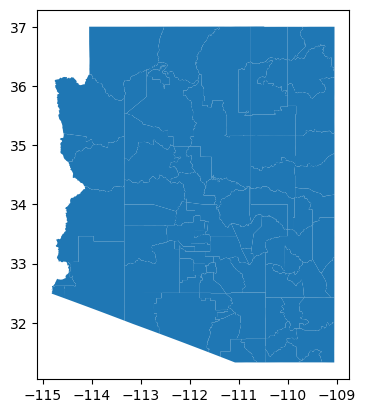

In [12]:
arizona.plot()

### Filter to Phoenix Subdivision
In this section I will filter the `arizona` gpd to the Phoenix region.

In [13]:
phoenix_az = arizona[arizona['NAME'] == 'Phoenix']

<Axes: >

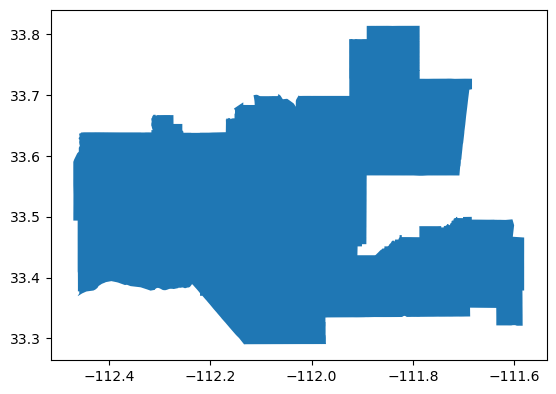

In [14]:
phoenix_az.plot()

In [15]:
# View the CRS of the phoenix_az df 
print('CRS: ', phoenix_az.crs)

CRS:  EPSG:4269


In order to plot the Phoenix subdivision I need to match the CRS of `phoenix_az` to the biodiversity rasters (`bio_2017` and `bio_2020`).

In [16]:
# Assert that both rasters have matching CRSs
assert bio_2017.rio.crs == bio_2020.rio.crs 

In [17]:
#Match CRS of Phoenix to bio_2017 raster 
phoenix_az = phoenix_az.to_crs(crs = bio_2017.rio.crs)

In [18]:
# Assert that CRS matches now
assert phoenix_az.crs == bio_2017.rio.crs

## Map 1: Pheonix Subdivision 

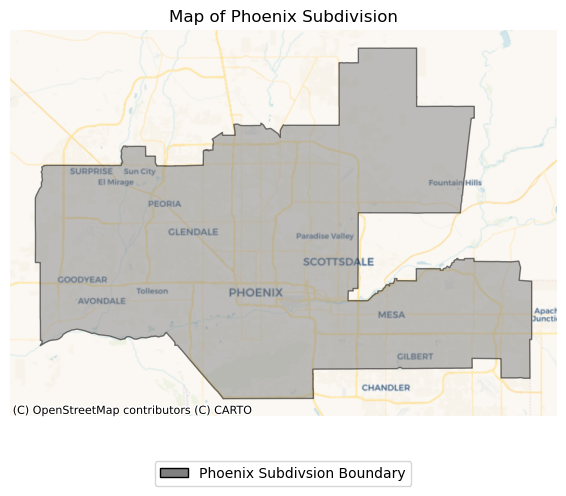

In [19]:
fig, ax = plt.subplots()# Initialize empty figure

# Plot phoenix border
phoenix_az.plot(ax = ax, alpha = 0.5, color = 'grey', edgecolor = 'black') 
# Add basemap 
cx.add_basemap(ax=ax, crs = bio_2020.rio.crs, source = cx.providers.CartoDB.Voyager) 
# Add title 
ax.set_title("Map of Phoenix Subdivision", fontsize=12) 
ax.axis('off')

# Add legend 
legend_elements = [mpatches.Patch(facecolor='grey', edgecolor='black',
label='Phoenix Subdivsion Boundary')]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5)

plt.tight_layout()
plt.show()

## Map 2: BII in Phoenix, AZ
In this section I will mproduce a map of the change in biodiversity from 2017 to 2020 in Phoenix, AZ. In order to do so, I need to perform the folowing:
- clip rasters to Phoenix subdivision
- filter the data to changes at least 0.75 BII

### Clip Rasters to Phoenix Subdivision
In this section, clipped the `bio_2017` and `bio_2020` rasters to the `pheonix_az` geometries with `rio.clip`.

In [20]:
# Clip 2017 and 2020 raster to Phoenix boundary with its geometry 
bio_2017 = bio_2017.rio.clip(phoenix_az.geometry) # match to phoenix geometries
bio_2020 = bio_2020.rio.clip(phoenix_az.geometry) # match to phoenix geometries         


View the clipped rasters. Ensure they are within the Phoenix subdivision boundary.

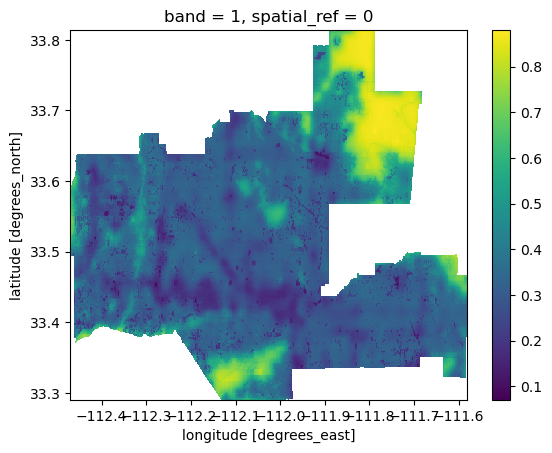

In [21]:
bio_2017.plot()

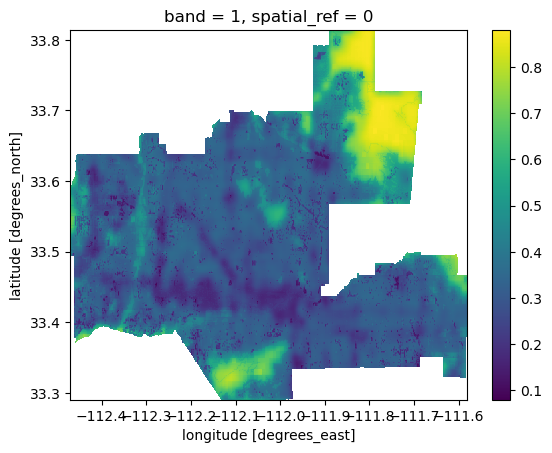

In [22]:
bio_2020.plot()

## Determine BII Change
In this section, I will calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020. In order to do so, I will perform the following:
- Mask the `bio_2017` and `bio_2020` rasters to remove cells outside of the rasters from the percentage calculation. 
- Filter the `bio_2017` and `bio_2020` raster to BII greater than or equal to 0.75
- Calculate the percent change of area 

This produces a boolean where 0 is the geometries that are not at least 0.75 BII and 1 for geometries that are at least 0.75 BII. 

In [23]:
# Mask 2017 raster
mask_2017 = bio_2017.where(bio_2017 != 'nan') # Filters for cells that are NOT nan
mask_2020 = bio_2020.where(bio_2020 != 'nan')

In [24]:

# Filter the bio_2017 raster to BII greater than or equal to 0.75 
bio_2017_filtered = mask_2017 >= 0.75 # produces a boolean
# Get percentage change 
perc_bio_2017 =(bio_2017_filtered.sum()/mask_2017.count()) * 100

print(f"The percentage of Phoenix subdivision with a BII of at least 0.75 in 2017 is {perc_bio_2017.item():.2f} %.")

The percentage of Phoenix subdivision with a BII of at least 0.75 in 2017 is 7.13 %.


In [25]:
# Filter the bio_2020 raster to BII greater than or equal to 0.75 
bio_2020_filtered = mask_2020 >= 0.75 # produces a boolean
# Get percentage change 
perc_bio_2020 =(bio_2020_filtered.sum()/mask_2020.count()) * 100

print(f"The percentage of Phoenix subdivision with a BII of at least 0.75 in 2020 is {perc_bio_2020.item():.2f} %.")

The percentage of Phoenix subdivision with a BII of at least 0.75 in 2020 is 6.49 %.


View the filtered rasters.

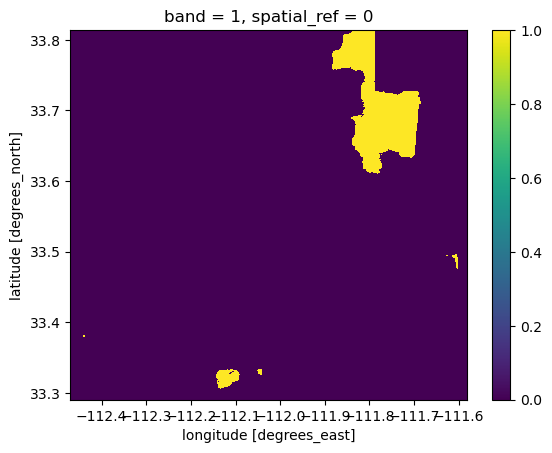

In [26]:
bio_2017_filtered.plot()

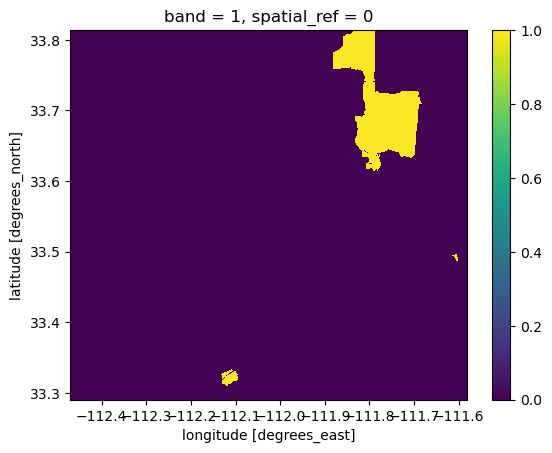

In [27]:
bio_2020_filtered.plot()

### Change Raster Data Type
In this section I changed the raster data type to be integers in order to do raster algebra in the next step.

In [28]:
# Change 2017 raster to be integers
bio_2017_int = bio_2017_filtered.astype(int)
# Change 2020 raster to be integer 
bio_2020_int = bio_2020_filtered.astype(int)

In [29]:
# subtract rasters to see difference 
bio_dif = bio_2017_int - bio_2020_int

Now I will find the change in biodiversity with the `.where()` function. This function keeps the values where the condition is true (where `bio_dif` is *not* zero) and replaces everything else with NaN. 

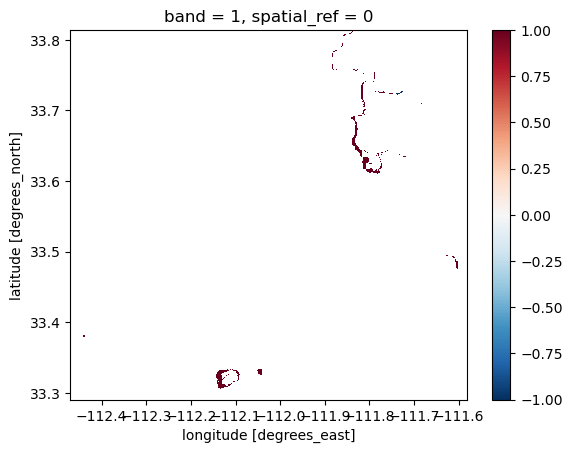

In [30]:
# Find the change in biodiversity 
bio_change = bio_dif.where(bio_dif != 0) # not zero
# Plot the change 
bio_change.plot()

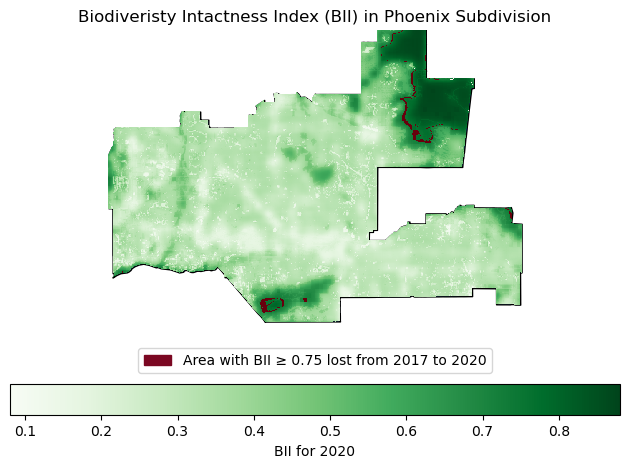

<Figure size 640x480 with 0 Axes>

In [31]:
fig, ax = plt.subplots()
ax.axis('off')

# Add phoenix border
phoenix_az.plot(ax = ax, edgecolor = 'black')

# Add 2017 plot as background
bio_2020.plot(ax = ax, cmap = 'Greens', cbar_kwargs = {'location': 'bottom', 'label':'BII for 2020'})     

# Add loss 
bio_change.plot(ax = ax, cmap = "Reds", add_colorbar = False)

# Add title
ax.set_title("Biodiveristy Intactness Index (BII) in Phoenix Subdivision", fontsize=12)

# Adjust legend
legend_elements = [mpatches.Patch(facecolor='#7b0722', edgecolor='#7b0722',
label='Area with BII ≥ 0.75 lost from 2017 to 2020')]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5)

plt.tight_layout()
plt.show()
plt.savefig('BII_map.png', dpi=300, transparent=True)

## Results and next steps


The map above depicts the loss in biodiversity from 2017 to 2020 in the Phoenix subdivision. This region encompasses many metropolitan areas that are facing large urban expansion. As you can see from the map above, there are two main *hotspots* for biodiversity loss in the map. These regions also correspond to regions with high biodiversity. This map is displaying how regions with previous high biodiversity are threatened the most as urbanization increases. Overall, from the three year time period investigated within this study, biodiversity reduced by around 0.64%. If I were to expand this study and if the `io-biodiversity` catalog contained the data, I would increase the time range to see the full scale of biodiversity loss from the start of the rapid urbanization in the subdivision around 2001. 

## References

United States Census Bureau. (2025). TIGER/Line Shapefile, 2023, State, Arizona, AZ, County Subdivision. Data.gov. https://catalog.data.gov/dataset/tiger-line-shapefile-2023-state-arizona-az-county-subdivision

Microsoft. (2025). Biodiversity Intactness [Dataset]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview

Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post, Aug. 2021, Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. [Accessed: Nov. 22, 2024] 

F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” (Aug. 2022.) Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf [Accessed: Dec. 6, 2025] 
